# DH-Parametertabelle youBot

$\begin{array}{rr} \hline
\mathbf{Gelenk} &\mathbf{\theta} &\mathbf{d} &\mathbf{a} &\mathbf{\alpha} \\ \hline
\mathbf{1} &0        &0.075 &0.033 &-\pi / 2 \\ \hline
\mathbf{2} &-\pi / 2 &0     &0.155 &0 \\ \hline
\mathbf{3} &0        &0     &0.135 &0 \\ \hline
\mathbf{4} &\pi / 2  &0     &0     &\pi / 2 \\ \hline
\mathbf{5} &\pi / 2  &0.218 &0     &0 \\ \hline
\end{array}$

DH Parameter

In [1]:
# import numpy as np

# dh_theta_values = np.array([0, -np.pi / 2, 0, np.pi / 2, np.pi / 2])
# dh_alpha_values = np.array([-np.pi / 2, 0, 0, np.pi / 2, 0])
# dh_a_values = np.array([0.033, 0.155, 0.135, 0, 0])
# dh_d_values = np.array([0.075, 0, 0, 0, 0.218])

Wir programmieren nun eine Python-Funktion <b>dhIthFrame</b> zur Erstellung eines einzelnen DH-Frames. Dabei übergeben wir noch keine Parameter, sondern bleiben gänzlich auf symbolischer Ebene mit $\theta$, $d$, $a$ und $\alpha$.

In [2]:
# def dhIthFrame(theta, d, a, alpha):
    
#     rot_theta = np.matrix([ [np.cos(theta), -np.sin(theta), 0, 0], 
#                             [np.sin(theta), np.cos(theta), 0, 0], [0, 0, 1, 0], 
#                             [0, 0, 0, 1] ])
    
#     trans_d = np.matrix([ [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d], [0, 0, 0, 1] ])
#     trans_a = np.matrix([ [1, 0, 0, a], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1] ])
    
#     rot_alpha = np.matrix([ [1, 0, 0, 0], 
#                             [0, np.cos(alpha), -np.sin(alpha), 0], 
#                             [0, np.sin(alpha), np.cos(alpha), 0], [0, 0, 0, 1] ])
    
#     dh_ith_frame = rot_theta * trans_d * trans_a * rot_alpha
    
#     return dh_ith_frame;

Dieses DH-Frame ist unsere Blaupause für die Forwärtstransformation am youBot. Wir definieren eine Python-Funktion <b>buildDhTcpFrame</b>, in welcher wir die Argumente eines solchen Blaupause-Frames durch die DH-Parameter und den Symbolen für die Gelenkwinkel $q_{1}$ bis $q_{5}$ iterativ substituieren und die resultierenden Frames zu einem Ergebnis-Frame akkumulieren. Anschließend vereinfachen wir noch das Ergebnis mit <b>trigsimp</b>.

In [3]:
# def buildDhTcpFrame(q_array):
#     dh_frame = np.identity(4)
      
#     for i in range(5):
#         tmp_dh_ith = dhIthFrame(q_array[i] + dh_theta_values[i], 
#                                 dh_d_values[i], 
#                                 dh_a_values[i], 
#                                 dh_alpha_values[i])
#         dh_frame = np.matmul(dh_frame, tmp_dh_ith)
    
#     return dh_frame

In [4]:
def normalize(data):
    dmax = np.radians(165)
    dmin = np.radians(-168)

    for i, arr in enumerate(data):
        for j, value in enumerate(arr):
            data[i][j] = (2 * (value - dmin) / (dmax - dmin)) - 1

In [5]:
def denormalize(data):
    dmax = np.radians(165)
    dmin = np.radians(-168)
    
    for i, arr in enumerate(data):
        for j, value in enumerate(arr):
            data[i][j] = (((value + 1) * (dmax - dmin)) / 2) + dmin

In [44]:
import utils

def generate_data(iterations=5):
    #Maximale und minimale Werte (based on robo freedom tests) */
    a1 = [165, -168]
    a2 = [85, -64]
    a3 = [145, -141]
    a4 = [101, -101]
    a5 = [155, -161]
    joint_limits = [a1, a2, a3, a4, a5]
    pos_arr = []
    for i in range(iterations):
        degree_joint_pos = []
        for joint_range in joint_limits:
            joint_val = np.random.randint(joint_range[1], joint_range[0] + 1)
            degree_joint_pos.append(joint_val)
        degree_joint_pos = np.asarray(degree_joint_pos)
        radians = np.radians(degree_joint_pos)
#         radians = degree_joint_pos
        pos_arr.append(radians)
    
    positions = np.asarray(pos_arr)
    
    tcp = []
    for i in range(iterations):
        frame = utils.buildDhTcpFrame(positions[i])
        frame = np.asarray(frame.flatten())
        frame = frame[0:, :12]
        frame = np.squeeze(frame)
#         xyz = frame[3::4]
#         frame[3] *= 100
#         frame[7] *= 100
#         frame[11] *= 100
        tcp.append(frame)

    tcp = np.asarray(tcp)

    return positions, tcp

In [179]:
def deleteDuplicate(tcp, pos):
    isDuplicate = []
    for i in range(len(tcp)):
        xyz = tcp[i][3::4]
        for j in range((i+1), len(tcp)):
            xyz_ = tcp[j][3::4]
            if xyz[0] == xyz_[0] and xyz[1] == xyz_[1] and xyz[2] == xyz_[2]:
                isDuplicate.append(i)
    
#     print(len(isDuplicate))
    new_tcp = np.delete(tcp, isDuplicate, 0)
    new_joint_pos = np.delete(pos, isDuplicate, 0)
    return new_tcp, new_joint_pos

Kuka YouBot Gelenkwinkelgrenzenin Grad [+/-]

In [243]:
for i in range(5):
    print(np.random.randint(1,6))

2
3
3
1
5


In [280]:
def generate_data_step(iterations=100):
    #Maximale und minimale Werte (based on robo freedom tests) */
    a1 = [165, -168]
    a2 = [85, -64]
    a3 = [145, -141]
    a4 = [101, -101]
    a5 = [155, -161]
    joint_limits = [a1, a2, a3, a4, a5]
    state = np.zeros(5)
    pos_arr = []
    
    
    for i in range(iterations):
        degree_joint_pos = []
        for i, joint_range in enumerate(joint_limits):
            step = (2*np.random.randint(0,2)-1) * np.random.randint(1,6)
            if((step + state[i]) > joint_range[0] or (step + state[i]) < joint_range[1]):
                step *= -np.random.randint(1,6)
            state[i]+= step
            degree_joint_pos.append(state[i])

        degree_joint_pos = np.asarray(degree_joint_pos)
        radians = np.radians(degree_joint_pos)
        pos_arr.append(radians)
    
#     for i, joint_range in enumerate(joint_limits):
#         for joint_val in range(joint_range[1], joint_range[0] + 1):
#             degree_joint_pos = []
#             for j in range(5):
#                 if i is j:
#                     degree_joint_pos.append(joint_val)
#                 else:
#                     degree_joint_pos.append(state[i])
            
#             degree_joint_pos = np.asarray(degree_joint_pos)
#             radians = np.radians(degree_joint_pos)
# #         radians = degree_joint_pos
#             pos_arr.append(radians)
#     state[i] = joint_range[0]
    
    positions = np.asarray(pos_arr)
    print("positions calculated")
    tcp = []
    for i in range(len(positions)):
        frame = utils.buildDhTcpFrame(positions[i])
        frame = np.asarray(frame.flatten())
        frame = frame[0:, :12]
        frame = np.squeeze(frame)
#         xyz = frame[3::4]
#         frame[3] *= 100
#         frame[7] *= 100
#         frame[11] *= 100
        tcp.append(frame)
    
    tcp = np.asarray(tcp)
    print("tcp calculated")
    tcp, positions = deleteDuplicate(tcp, positions)
    print("duplicates erased")
    return positions, tcp

In [185]:
ppos, ttcp = generate_data_step(10000)
print(len(ttcp))
print(len(ppos))

positions calculated
tcp calculated
duplicates erased
8972
8972


Generiere eine Anzahl von zufälligen Gelenkwinkelpositionen und dazugehöriges TCP Frame

In [7]:
import time
import numpy as np

start = time.time()

joint_pos, tcp_pos = generate_data(100)
# max_tcp = np.amax(np.absolute(tcp_positions))
# tcp_positions = tcp_positions / max_tcp
end = time.time()
print(end - start)

0.13310742378234863


In [8]:
print("TCP Shape:", tcp_pos.shape)
print("Joint Shape:", joint_pos.shape)

TCP Shape: (100, 12)
Joint Shape: (100, 5)


<IPython.core.display.Javascript object>


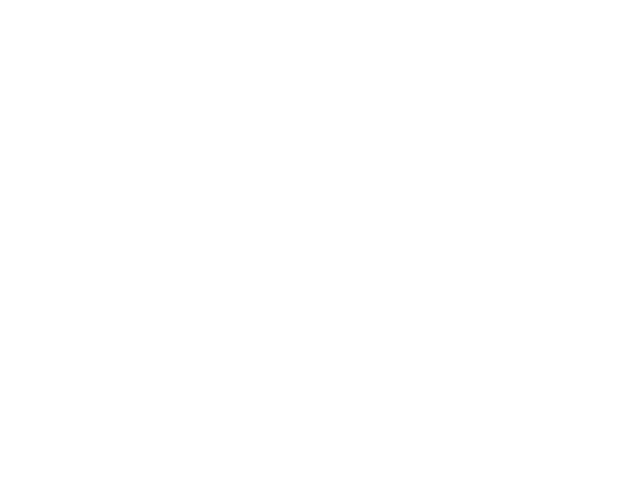

In [9]:
from mpl_toolkits import mplot3d
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from pytransform3d.rotations import *
%matplotlib notebook

tcp = tcp_pos

ax = plot_basis(R=np.eye(3), ax_s=5)
f = 5
samples = np.random.randint(0, len(tcp), 5)
for i in samples:
    point = np.asarray([tcp[i][3] *f, tcp[i][7] *f, tcp[i][11] *f])
    rot = np.asarray([[tcp[i][0], tcp[i][1], tcp[i][2]],
                      [tcp[i][4], tcp[i][5], tcp[i][6]],
                      [tcp[i][8], tcp[i][9], tcp[i][10]]])
    plot_basis(ax, R=rot, p=point)

plt.show()


In [273]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization

model = Sequential()
    
# layer = Dense(units=100, 
#           input_dim=12,
#           kernel_initializer='random_normal',
#           use_bias=True,
#           bias_initializer='random_normal',
#           activation='tanh')
layer = Dense(units=500, 
          input_dim=12,
          kernel_initializer='random_normal',
          use_bias=False)

model.add(layer)
model.add(BatchNormalization())
model.add(Activation('tanh'))

dropout = Dropout(0.5)
model.add(dropout)

hidden_layers = 2

for i in range(hidden_layers):
#     layer = Dense(units=100, 
#                   kernel_initializer='random_normal',
#                   use_bias=True,
#                   bias_initializer='random_normal',
#                   activation='tanh')
    layer = Dense(units=500, 
                  kernel_initializer='random_normal',
                  use_bias=False)
    model.add(layer)
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    if i is not (hidden_layers - 1):
        dropout = Dropout(0.5)
        model.add(dropout)
    
# layer = Dense(units=5, 
#               kernel_initializer='random_normal',
#               use_bias=True,
#               bias_initializer='random_normal',
#               activation='tanh')
layer = Dense(units=5, 
              kernel_initializer='random_normal',
              use_bias=False,
              activation='tanh')
model.add(layer)

In [12]:
# ygtt, ypredt = gen(2)
# custom_loss(ygtt[1], ypredt[1])

In [348]:
from keras.optimizers import RMSprop
from keras.optimizers import Adam
# For a mean squared error regression problem
rms = RMSprop(learning_rate=0.01, rho=0.9)
adam=Adam(lr=1.0e-3)

model.compile(optimizer=adam,loss='mse')

In [275]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 500)               6000      
_________________________________________________________________
batch_normalization_9 (Batch (None, 500)               2000      
_________________________________________________________________
activation_9 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 500)               250000    
_________________________________________________________________
batch_normalization_10 (Batc (None, 500)               2000      
_________________________________________________________________
activation_10 (Activation)   (None, 500)              

In [283]:
import keras.utils as tf

def gen(batch_size):
#     jpos, tcp = generate_data(batch_size)
    jpos, tcp = generate_data_step(batch_size)
    normalize(jpos)
    tpos = tf.normalize(tcp, axis=-1, order=2)
    return jpos, tpos

In [33]:
eins = [0.19392999, 0.06677545, 0.0319066 ]
zwei = [0.19392999, 0.06677545, 0.0319066 ]

if eins == zwei:
    print(True)

True


In [267]:
jpos, tpos = gen(100)
# isDuplicate(tpos)
print(len(jpos))

100


In [284]:
from utils import Generator

# generator = Generator()
# model.fit(tpos, jpos, epochs=300, batch_size=90000, validation_split=0.1)
for i in range(10):
    print("Durchlauf: ",i)
    jpos, tpos = gen(10000)
    model.fit(tpos, jpos, epochs=1000, batch_size=10000, validation_split=0.1)

Durchlauf:  0
positions calculated
tcp calculated
duplicates erased
Train on 8996 samples, validate on 1000 samples
Epoch 1/1000
8996/8996 [==============================] - 0s 10us/step - loss: 0.1567 - val_loss: 0.0674
Epoch 2/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.1499 - val_loss: 0.0644
Epoch 3/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.1392 - val_loss: 0.0614
Epoch 4/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.1283 - val_loss: 0.0593
Epoch 5/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.1174 - val_loss: 0.0588
Epoch 6/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.1093 - val_loss: 0.0597
Epoch 7/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.1038 - val_loss: 0.0618
Epoch 8/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.1001 - val_loss: 0.0648
Epoch 9/1000
8996/8996 [===========================

Epoch 78/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0388 - val_loss: 0.0476
Epoch 79/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0389 - val_loss: 0.0476
Epoch 80/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0381 - val_loss: 0.0475
Epoch 81/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0380 - val_loss: 0.0474
Epoch 82/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0377 - val_loss: 0.0473
Epoch 83/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0377 - val_loss: 0.0472
Epoch 84/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0370 - val_loss: 0.0471
Epoch 85/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0371 - val_loss: 0.0470
Epoch 86/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0365 - val_loss: 0.0470
Epoch 87/1000
8996/8996 [==============================

Epoch 156/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0272 - val_loss: 0.0441
Epoch 157/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0272 - val_loss: 0.0440
Epoch 158/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0274 - val_loss: 0.0440
Epoch 159/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0269 - val_loss: 0.0440
Epoch 160/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0263 - val_loss: 0.0440
Epoch 161/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0266 - val_loss: 0.0440
Epoch 162/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0265 - val_loss: 0.0440
Epoch 163/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0267 - val_loss: 0.0440
Epoch 164/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0263 - val_loss: 0.0440
Epoch 165/1000
8996/8996 [====================

Epoch 234/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0221 - val_loss: 0.0420
Epoch 235/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0219 - val_loss: 0.0419
Epoch 236/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0222 - val_loss: 0.0419
Epoch 237/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0220 - val_loss: 0.0418
Epoch 238/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0220 - val_loss: 0.0418
Epoch 239/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0220 - val_loss: 0.0418
Epoch 240/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0218 - val_loss: 0.0418
Epoch 241/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0217 - val_loss: 0.0418
Epoch 242/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0219 - val_loss: 0.0419
Epoch 243/1000
8996/8996 [====================

Epoch 312/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0189 - val_loss: 0.0412
Epoch 313/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0190 - val_loss: 0.0412
Epoch 314/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0192 - val_loss: 0.0412
Epoch 315/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0189 - val_loss: 0.0411
Epoch 316/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0191 - val_loss: 0.0411
Epoch 317/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0188 - val_loss: 0.0410
Epoch 318/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0188 - val_loss: 0.0409
Epoch 319/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0191 - val_loss: 0.0409
Epoch 320/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0188 - val_loss: 0.0409
Epoch 321/1000
8996/8996 [====================

Epoch 390/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0171 - val_loss: 0.0406
Epoch 391/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0173 - val_loss: 0.0406
Epoch 392/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 393/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 394/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0170 - val_loss: 0.0405
Epoch 395/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0169 - val_loss: 0.0405
Epoch 396/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0172 - val_loss: 0.0406
Epoch 397/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0170 - val_loss: 0.0406
Epoch 398/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0169 - val_loss: 0.0406
Epoch 399/1000
8996/8996 [====================

Epoch 468/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0157 - val_loss: 0.0403
Epoch 469/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0157 - val_loss: 0.0403
Epoch 470/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0158 - val_loss: 0.0403
Epoch 471/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0156 - val_loss: 0.0404
Epoch 472/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0155 - val_loss: 0.0403
Epoch 473/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0155 - val_loss: 0.0403
Epoch 474/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0157 - val_loss: 0.0403
Epoch 475/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0155 - val_loss: 0.0403
Epoch 476/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0156 - val_loss: 0.0403
Epoch 477/1000
8996/8996 [====================

Epoch 546/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0143 - val_loss: 0.0400
Epoch 547/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0144 - val_loss: 0.0400
Epoch 548/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0147 - val_loss: 0.0400
Epoch 549/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0145 - val_loss: 0.0400
Epoch 550/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0143 - val_loss: 0.0400
Epoch 551/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0146 - val_loss: 0.0400
Epoch 552/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0144 - val_loss: 0.0400
Epoch 553/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0144 - val_loss: 0.0401
Epoch 554/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0142 - val_loss: 0.0402
Epoch 555/1000
8996/8996 [====================

Epoch 624/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0135 - val_loss: 0.0401
Epoch 625/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0135 - val_loss: 0.0402
Epoch 626/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0136 - val_loss: 0.0402
Epoch 627/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0138 - val_loss: 0.0403
Epoch 628/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0135 - val_loss: 0.0403
Epoch 629/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0134 - val_loss: 0.0403
Epoch 630/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0138 - val_loss: 0.0403
Epoch 631/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0134 - val_loss: 0.0404
Epoch 632/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0137 - val_loss: 0.0404
Epoch 633/1000
8996/8996 [====================

Epoch 702/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0128 - val_loss: 0.0402
Epoch 703/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0131 - val_loss: 0.0403
Epoch 704/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0127 - val_loss: 0.0403
Epoch 705/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0129 - val_loss: 0.0404
Epoch 706/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0129 - val_loss: 0.0404
Epoch 707/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0129 - val_loss: 0.0404
Epoch 708/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0129 - val_loss: 0.0404
Epoch 709/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0127 - val_loss: 0.0404
Epoch 710/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0128 - val_loss: 0.0403
Epoch 711/1000
8996/8996 [====================

Epoch 780/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0125 - val_loss: 0.0405
Epoch 781/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0121 - val_loss: 0.0405
Epoch 782/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0123 - val_loss: 0.0405
Epoch 783/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0122 - val_loss: 0.0405
Epoch 784/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0119 - val_loss: 0.0404
Epoch 785/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0121 - val_loss: 0.0404
Epoch 786/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0120 - val_loss: 0.0403
Epoch 787/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0121 - val_loss: 0.0403
Epoch 788/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0122 - val_loss: 0.0403
Epoch 789/1000
8996/8996 [====================

Epoch 858/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0116 - val_loss: 0.0405
Epoch 859/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0118 - val_loss: 0.0406
Epoch 860/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0115 - val_loss: 0.0406
Epoch 861/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0116 - val_loss: 0.0407
Epoch 862/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0117 - val_loss: 0.0407
Epoch 863/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0115 - val_loss: 0.0407
Epoch 864/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0115 - val_loss: 0.0407
Epoch 865/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0117 - val_loss: 0.0406
Epoch 866/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0115 - val_loss: 0.0406
Epoch 867/1000
8996/8996 [====================

Epoch 936/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0112 - val_loss: 0.0407
Epoch 937/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0111 - val_loss: 0.0407
Epoch 938/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0111 - val_loss: 0.0407
Epoch 939/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0109 - val_loss: 0.0406
Epoch 940/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0110 - val_loss: 0.0406
Epoch 941/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0111 - val_loss: 0.0406
Epoch 942/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0111 - val_loss: 0.0406
Epoch 943/1000
8996/8996 [==============================] - 0s 9us/step - loss: 0.0108 - val_loss: 0.0406
Epoch 944/1000
8996/8996 [==============================] - 0s 8us/step - loss: 0.0110 - val_loss: 0.0406
Epoch 945/1000
8996/8996 [====================

Epoch 13/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0940 - val_loss: 0.1126
Epoch 14/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0924 - val_loss: 0.1108
Epoch 15/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0894 - val_loss: 0.1092
Epoch 16/1000
9000/9000 [==============================] - 0s 9us/step - loss: 0.0862 - val_loss: 0.1081
Epoch 17/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0837 - val_loss: 0.1072
Epoch 18/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0791 - val_loss: 0.1053
Epoch 19/1000
9000/9000 [==============================] - 0s 9us/step - loss: 0.0754 - val_loss: 0.1015
Epoch 20/1000
9000/9000 [==============================] - 0s 9us/step - loss: 0.0716 - val_loss: 0.0969
Epoch 21/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0678 - val_loss: 0.0931
Epoch 22/1000
9000/9000 [==============================

9000/9000 [==============================] - 0s 8us/step - loss: 0.0222 - val_loss: 0.0560
Epoch 92/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0222 - val_loss: 0.0558
Epoch 93/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0221 - val_loss: 0.0557
Epoch 94/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0217 - val_loss: 0.0557
Epoch 95/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0215 - val_loss: 0.0557
Epoch 96/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0216 - val_loss: 0.0558
Epoch 97/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0217 - val_loss: 0.0559
Epoch 98/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0214 - val_loss: 0.0560
Epoch 99/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0215 - val_loss: 0.0561
Epoch 100/1000
9000/9000 [==============================] - 0s 7us/st

Epoch 169/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0167 - val_loss: 0.0507
Epoch 170/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0165 - val_loss: 0.0507
Epoch 171/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0169 - val_loss: 0.0506
Epoch 172/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0167 - val_loss: 0.0505
Epoch 173/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0166 - val_loss: 0.0503
Epoch 174/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0166 - val_loss: 0.0503
Epoch 175/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0163 - val_loss: 0.0503
Epoch 176/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0164 - val_loss: 0.0503
Epoch 177/1000
9000/9000 [==============================] - 0s 9us/step - loss: 0.0162 - val_loss: 0.0503
Epoch 178/1000
9000/9000 [====================

Epoch 247/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0141 - val_loss: 0.0463
Epoch 248/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0141 - val_loss: 0.0463
Epoch 249/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0141 - val_loss: 0.0463
Epoch 250/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0141 - val_loss: 0.0462
Epoch 251/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0141 - val_loss: 0.0462
Epoch 252/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0140 - val_loss: 0.0462
Epoch 253/1000
9000/9000 [==============================] - 0s 6us/step - loss: 0.0139 - val_loss: 0.0461
Epoch 254/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0139 - val_loss: 0.0461
Epoch 255/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0139 - val_loss: 0.0460
Epoch 256/1000
9000/9000 [====================

Epoch 325/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0126 - val_loss: 0.0439
Epoch 326/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0127 - val_loss: 0.0438
Epoch 327/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0126 - val_loss: 0.0438
Epoch 328/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0127 - val_loss: 0.0438
Epoch 329/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0125 - val_loss: 0.0438
Epoch 330/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0126 - val_loss: 0.0437
Epoch 331/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0125 - val_loss: 0.0437
Epoch 332/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0126 - val_loss: 0.0435
Epoch 333/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0126 - val_loss: 0.0434
Epoch 334/1000
9000/9000 [====================

Epoch 403/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0116 - val_loss: 0.0421
Epoch 404/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0115 - val_loss: 0.0422
Epoch 405/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0116 - val_loss: 0.0422
Epoch 406/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0115 - val_loss: 0.0421
Epoch 407/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0115 - val_loss: 0.0421
Epoch 408/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0115 - val_loss: 0.0421
Epoch 409/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0115 - val_loss: 0.0420
Epoch 410/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0114 - val_loss: 0.0418
Epoch 411/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0114 - val_loss: 0.0416
Epoch 412/1000
9000/9000 [====================

Epoch 481/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0106 - val_loss: 0.0407
Epoch 482/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0107 - val_loss: 0.0407
Epoch 483/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0108 - val_loss: 0.0408
Epoch 484/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0107 - val_loss: 0.0408
Epoch 485/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0108 - val_loss: 0.0408
Epoch 486/1000
9000/9000 [==============================] - 0s 6us/step - loss: 0.0105 - val_loss: 0.0408
Epoch 487/1000
9000/9000 [==============================] - 0s 6us/step - loss: 0.0105 - val_loss: 0.0407
Epoch 488/1000
9000/9000 [==============================] - 0s 6us/step - loss: 0.0108 - val_loss: 0.0407
Epoch 489/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0104 - val_loss: 0.0406
Epoch 490/1000
9000/9000 [====================

Epoch 559/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0100 - val_loss: 0.0400
Epoch 560/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0102 - val_loss: 0.0401
Epoch 561/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0101 - val_loss: 0.0400
Epoch 562/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0101 - val_loss: 0.0400
Epoch 563/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0101 - val_loss: 0.0398
Epoch 564/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0101 - val_loss: 0.0397
Epoch 565/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0102 - val_loss: 0.0397
Epoch 566/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0101 - val_loss: 0.0397
Epoch 567/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0099 - val_loss: 0.0397
Epoch 568/1000
9000/9000 [====================

Epoch 637/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0096 - val_loss: 0.0393
Epoch 638/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0096 - val_loss: 0.0393
Epoch 639/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0096 - val_loss: 0.0393
Epoch 640/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0095 - val_loss: 0.0392
Epoch 641/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0095 - val_loss: 0.0391
Epoch 642/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0095 - val_loss: 0.0391
Epoch 643/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0095 - val_loss: 0.0391
Epoch 644/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0095 - val_loss: 0.0391
Epoch 645/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0094 - val_loss: 0.0391
Epoch 646/1000
9000/9000 [====================

Epoch 715/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0090 - val_loss: 0.0385
Epoch 716/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0091 - val_loss: 0.0385
Epoch 717/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0089 - val_loss: 0.0384
Epoch 718/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0089 - val_loss: 0.0384
Epoch 719/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0091 - val_loss: 0.0384
Epoch 720/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0090 - val_loss: 0.0383
Epoch 721/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0090 - val_loss: 0.0384
Epoch 722/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0090 - val_loss: 0.0384
Epoch 723/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0090 - val_loss: 0.0384
Epoch 724/1000
9000/9000 [====================

Epoch 793/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0085 - val_loss: 0.0381
Epoch 794/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0086 - val_loss: 0.0379
Epoch 795/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0086 - val_loss: 0.0379
Epoch 796/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0086 - val_loss: 0.0379
Epoch 797/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0088 - val_loss: 0.0380
Epoch 798/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0087 - val_loss: 0.0380
Epoch 799/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0085 - val_loss: 0.0379
Epoch 800/1000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0087 - val_loss: 0.0378
Epoch 801/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0087 - val_loss: 0.0378
Epoch 802/1000
9000/9000 [====================

Epoch 871/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0084 - val_loss: 0.0377
Epoch 872/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0083 - val_loss: 0.0378
Epoch 873/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0083 - val_loss: 0.0378
Epoch 874/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0083 - val_loss: 0.0377
Epoch 875/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0082 - val_loss: 0.0377
Epoch 876/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0083 - val_loss: 0.0376
Epoch 877/1000
9000/9000 [==============================] - 0s 9us/step - loss: 0.0083 - val_loss: 0.0375
Epoch 878/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0083 - val_loss: 0.0376
Epoch 879/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0082 - val_loss: 0.0377
Epoch 880/1000
9000/9000 [====================

Epoch 949/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0079 - val_loss: 0.0374
Epoch 950/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0080 - val_loss: 0.0373
Epoch 951/1000
9000/9000 [==============================] - 0s 9us/step - loss: 0.0079 - val_loss: 0.0373
Epoch 952/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0080 - val_loss: 0.0373
Epoch 953/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0079 - val_loss: 0.0374
Epoch 954/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0080 - val_loss: 0.0374
Epoch 955/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0080 - val_loss: 0.0374
Epoch 956/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0080 - val_loss: 0.0373
Epoch 957/1000
9000/9000 [==============================] - 0s 8us/step - loss: 0.0080 - val_loss: 0.0371
Epoch 958/1000
9000/9000 [====================

Epoch 26/1000
8998/8998 [==============================] - 0s 10us/step - loss: 0.0522 - val_loss: 0.1021
Epoch 27/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0494 - val_loss: 0.0961
Epoch 28/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0469 - val_loss: 0.0916
Epoch 29/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0454 - val_loss: 0.0897
Epoch 30/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0452 - val_loss: 0.0904
Epoch 31/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0447 - val_loss: 0.0937
Epoch 32/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0434 - val_loss: 0.0991
Epoch 33/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0417 - val_loss: 0.1057
Epoch 34/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0404 - val_loss: 0.1115
Epoch 35/1000
8998/8998 [=============================

Epoch 104/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0219 - val_loss: 0.0964
Epoch 105/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0216 - val_loss: 0.0964
Epoch 106/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0215 - val_loss: 0.0963
Epoch 107/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0215 - val_loss: 0.0963
Epoch 108/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0215 - val_loss: 0.0960
Epoch 109/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0216 - val_loss: 0.0959
Epoch 110/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0213 - val_loss: 0.0956
Epoch 111/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0212 - val_loss: 0.0953
Epoch 112/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0209 - val_loss: 0.0953
Epoch 113/1000
8998/8998 [====================

Epoch 182/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0170 - val_loss: 0.0954
Epoch 183/1000
8998/8998 [==============================] - 0s 10us/step - loss: 0.0169 - val_loss: 0.0953
Epoch 184/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0171 - val_loss: 0.0951
Epoch 185/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0168 - val_loss: 0.0951
Epoch 186/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0165 - val_loss: 0.0951
Epoch 187/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0168 - val_loss: 0.0950
Epoch 188/1000
8998/8998 [==============================] - 0s 10us/step - loss: 0.0167 - val_loss: 0.0951
Epoch 189/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0165 - val_loss: 0.0951
Epoch 190/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0168 - val_loss: 0.0951
Epoch 191/1000
8998/8998 [==================

8998/8998 [==============================] - 0s 9us/step - loss: 0.0144 - val_loss: 0.0939
Epoch 260/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0146 - val_loss: 0.0939
Epoch 261/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0143 - val_loss: 0.0940
Epoch 262/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0145 - val_loss: 0.0942
Epoch 263/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0143 - val_loss: 0.0945
Epoch 264/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0145 - val_loss: 0.0947
Epoch 265/1000
8998/8998 [==============================] - 0s 10us/step - loss: 0.0144 - val_loss: 0.0949
Epoch 266/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0145 - val_loss: 0.0949
Epoch 267/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0143 - val_loss: 0.0945
Epoch 268/1000
8998/8998 [==============================] - 

Epoch 337/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0129 - val_loss: 0.0929
Epoch 338/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0126 - val_loss: 0.0927
Epoch 339/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0129 - val_loss: 0.0926
Epoch 340/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0131 - val_loss: 0.0925
Epoch 341/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0128 - val_loss: 0.0926
Epoch 342/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0131 - val_loss: 0.0927
Epoch 343/1000
8998/8998 [==============================] - 0s 10us/step - loss: 0.0129 - val_loss: 0.0930
Epoch 344/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0129 - val_loss: 0.0933
Epoch 345/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0131 - val_loss: 0.0933
Epoch 346/1000
8998/8998 [===================

Epoch 415/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0118 - val_loss: 0.0910
Epoch 416/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0119 - val_loss: 0.0911
Epoch 417/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0116 - val_loss: 0.0912
Epoch 418/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0116 - val_loss: 0.0914
Epoch 419/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0118 - val_loss: 0.0916
Epoch 420/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0117 - val_loss: 0.0916
Epoch 421/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0118 - val_loss: 0.0914
Epoch 422/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0119 - val_loss: 0.0913
Epoch 423/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0117 - val_loss: 0.0912
Epoch 424/1000
8998/8998 [====================

Epoch 493/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0109 - val_loss: 0.0904
Epoch 494/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0108 - val_loss: 0.0902
Epoch 495/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0109 - val_loss: 0.0900
Epoch 496/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0109 - val_loss: 0.0900
Epoch 497/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0109 - val_loss: 0.0900
Epoch 498/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0108 - val_loss: 0.0902
Epoch 499/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0109 - val_loss: 0.0903
Epoch 500/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0108 - val_loss: 0.0905
Epoch 501/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0108 - val_loss: 0.0904
Epoch 502/1000
8998/8998 [====================

Epoch 571/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0103 - val_loss: 0.0890
Epoch 572/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0103 - val_loss: 0.0888
Epoch 573/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0102 - val_loss: 0.0885
Epoch 574/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0104 - val_loss: 0.0884
Epoch 575/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0102 - val_loss: 0.0884
Epoch 576/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0100 - val_loss: 0.0885
Epoch 577/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0102 - val_loss: 0.0889
Epoch 578/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0101 - val_loss: 0.0892
Epoch 579/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0102 - val_loss: 0.0895
Epoch 580/1000
8998/8998 [====================

Epoch 649/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0095 - val_loss: 0.0883
Epoch 650/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0096 - val_loss: 0.0883
Epoch 651/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0095 - val_loss: 0.0880
Epoch 652/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0096 - val_loss: 0.0877
Epoch 653/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0096 - val_loss: 0.0875
Epoch 654/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0096 - val_loss: 0.0872
Epoch 655/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0097 - val_loss: 0.0872
Epoch 656/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0095 - val_loss: 0.0871
Epoch 657/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0099 - val_loss: 0.0872
Epoch 658/1000
8998/8998 [====================

Epoch 727/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0092 - val_loss: 0.0866
Epoch 728/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0092 - val_loss: 0.0866
Epoch 729/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0094 - val_loss: 0.0865
Epoch 730/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0092 - val_loss: 0.0864
Epoch 731/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0090 - val_loss: 0.0863
Epoch 732/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0090 - val_loss: 0.0863
Epoch 733/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0091 - val_loss: 0.0863
Epoch 734/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0091 - val_loss: 0.0863
Epoch 735/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0091 - val_loss: 0.0864
Epoch 736/1000
8998/8998 [====================

Epoch 805/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0086 - val_loss: 0.0857
Epoch 806/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0088 - val_loss: 0.0857
Epoch 807/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0088 - val_loss: 0.0859
Epoch 808/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0088 - val_loss: 0.0860
Epoch 809/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0088 - val_loss: 0.0860
Epoch 810/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0087 - val_loss: 0.0860
Epoch 811/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0087 - val_loss: 0.0859
Epoch 812/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0089 - val_loss: 0.0858
Epoch 813/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0087 - val_loss: 0.0859
Epoch 814/1000
8998/8998 [====================

Epoch 883/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0084 - val_loss: 0.0847
Epoch 884/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0085 - val_loss: 0.0847
Epoch 885/1000
8998/8998 [==============================] - 0s 10us/step - loss: 0.0085 - val_loss: 0.0848
Epoch 886/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0084 - val_loss: 0.0851
Epoch 887/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0083 - val_loss: 0.0853
Epoch 888/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0083 - val_loss: 0.0856
Epoch 889/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0084 - val_loss: 0.0857
Epoch 890/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0084 - val_loss: 0.0856
Epoch 891/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0084 - val_loss: 0.0854
Epoch 892/1000
8998/8998 [===================

Epoch 961/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0080 - val_loss: 0.0848
Epoch 962/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0080 - val_loss: 0.0847
Epoch 963/1000
8998/8998 [==============================] - 0s 10us/step - loss: 0.0080 - val_loss: 0.0848
Epoch 964/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0081 - val_loss: 0.0849
Epoch 965/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0080 - val_loss: 0.0849
Epoch 966/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0080 - val_loss: 0.0849
Epoch 967/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0083 - val_loss: 0.0849
Epoch 968/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0081 - val_loss: 0.0850
Epoch 969/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0080 - val_loss: 0.0849
Epoch 970/1000
8998/8998 [===================

Epoch 38/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0202 - val_loss: 0.0400
Epoch 39/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0201 - val_loss: 0.0399
Epoch 40/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0199 - val_loss: 0.0395
Epoch 41/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0200 - val_loss: 0.0388
Epoch 42/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0199 - val_loss: 0.0379
Epoch 43/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0192 - val_loss: 0.0368
Epoch 44/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0186 - val_loss: 0.0357
Epoch 45/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0185 - val_loss: 0.0347
Epoch 46/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0180 - val_loss: 0.0339
Epoch 47/1000
8998/8998 [==============================

Epoch 116/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0112 - val_loss: 0.0280
Epoch 117/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0113 - val_loss: 0.0279
Epoch 118/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0113 - val_loss: 0.0279
Epoch 119/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0111 - val_loss: 0.0279
Epoch 120/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0111 - val_loss: 0.0279
Epoch 121/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0111 - val_loss: 0.0279
Epoch 122/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0110 - val_loss: 0.0277
Epoch 123/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0109 - val_loss: 0.0275
Epoch 124/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0108 - val_loss: 0.0274
Epoch 125/1000
8998/8998 [====================

Epoch 194/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0090 - val_loss: 0.0256
Epoch 195/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0089 - val_loss: 0.0256
Epoch 196/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0090 - val_loss: 0.0256
Epoch 197/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0089 - val_loss: 0.0256
Epoch 198/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0090 - val_loss: 0.0256
Epoch 199/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0089 - val_loss: 0.0256
Epoch 200/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0090 - val_loss: 0.0255
Epoch 201/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0089 - val_loss: 0.0255
Epoch 202/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0088 - val_loss: 0.0255
Epoch 203/1000
8998/8998 [====================

Epoch 272/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0078 - val_loss: 0.0239
Epoch 273/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0077 - val_loss: 0.0240
Epoch 274/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0077 - val_loss: 0.0241
Epoch 275/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0076 - val_loss: 0.0242
Epoch 276/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0076 - val_loss: 0.0241
Epoch 277/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0077 - val_loss: 0.0240
Epoch 278/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0076 - val_loss: 0.0238
Epoch 279/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0077 - val_loss: 0.0237
Epoch 280/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0076 - val_loss: 0.0238
Epoch 281/1000
8998/8998 [====================

Epoch 350/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0070 - val_loss: 0.0232
Epoch 351/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0070 - val_loss: 0.0231
Epoch 352/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0069 - val_loss: 0.0229
Epoch 353/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0069 - val_loss: 0.0228
Epoch 354/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0071 - val_loss: 0.0228
Epoch 355/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0070 - val_loss: 0.0229
Epoch 356/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0069 - val_loss: 0.0230
Epoch 357/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0070 - val_loss: 0.0231
Epoch 358/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0069 - val_loss: 0.0230
Epoch 359/1000
8998/8998 [====================

Epoch 428/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0066 - val_loss: 0.0224
Epoch 429/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0064 - val_loss: 0.0223
Epoch 430/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0064 - val_loss: 0.0223
Epoch 431/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0064 - val_loss: 0.0223
Epoch 432/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0224
Epoch 433/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0224
Epoch 434/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0064 - val_loss: 0.0223
Epoch 435/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0222
Epoch 436/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0063 - val_loss: 0.0223
Epoch 437/1000
8998/8998 [====================

Epoch 506/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0060 - val_loss: 0.0218
Epoch 507/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0060 - val_loss: 0.0218
Epoch 508/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0060 - val_loss: 0.0217
Epoch 509/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0060 - val_loss: 0.0217
Epoch 510/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0061 - val_loss: 0.0218
Epoch 511/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0060 - val_loss: 0.0217
Epoch 512/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0059 - val_loss: 0.0217
Epoch 513/1000
8998/8998 [==============================] - 0s 7us/step - loss: 0.0060 - val_loss: 0.0217
Epoch 514/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0061 - val_loss: 0.0217
Epoch 515/1000
8998/8998 [====================

Epoch 584/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0056 - val_loss: 0.0213
Epoch 585/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0058 - val_loss: 0.0212
Epoch 586/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0057 - val_loss: 0.0212
Epoch 587/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0058 - val_loss: 0.0212
Epoch 588/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0057 - val_loss: 0.0213
Epoch 589/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0058 - val_loss: 0.0214
Epoch 590/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0058 - val_loss: 0.0214
Epoch 591/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0058 - val_loss: 0.0214
Epoch 592/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0057 - val_loss: 0.0213
Epoch 593/1000
8998/8998 [====================

Epoch 662/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0055 - val_loss: 0.0208
Epoch 663/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0054 - val_loss: 0.0208
Epoch 664/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0054 - val_loss: 0.0209
Epoch 665/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0055 - val_loss: 0.0210
Epoch 666/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0054 - val_loss: 0.0211
Epoch 667/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0054 - val_loss: 0.0211
Epoch 668/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0054 - val_loss: 0.0211
Epoch 669/1000
8998/8998 [==============================] - 0s 9us/step - loss: 0.0054 - val_loss: 0.0210
Epoch 670/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0054 - val_loss: 0.0210
Epoch 671/1000
8998/8998 [====================

Epoch 740/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0052 - val_loss: 0.0206
Epoch 741/1000
8998/8998 [==============================] - 0s 8us/step - loss: 0.0053 - val_loss: 0.0206
Epoch 742/1000


KeyboardInterrupt: 

In [279]:

model.fit_generator(generator = Generator().make(20), 
                    validation_data  = Generator().make(10),
                    steps_per_epoch  = 1000, 
                    epochs           = 200,
                    validation_steps = 100,
                    workers = 6,
                    use_multiprocessing = True)

Epoch 1/200


/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 3s 30ms/step - loss: 0.1903 - val_loss: 0.1109
Epoch 2/200
100/100 [==============================] - 2s 16ms/step - loss: 0.2188 - val_loss: 0.2961
Epoch 3/200
100/100 [==============================] - 2s 16ms/step - loss: 0.2323 - val_loss: 0.1918
Epoch 4/200
100/100 [==============================] - 2s 15ms/step - loss: 0.2096 - val_loss: 0.1639
Epoch 5/200
100/100 [==============================] - 2s 15ms/step - loss: 0.1960 - val_loss: 0.1656
Epoch 6/200
100/100 [==============================] - 2s 17ms/step - loss: 0.1840 - val_loss: 0.1031
Epoch 7/200
100/100 [==============================] - 2s 16ms/step - loss: 0.1756 - val_loss: 0.1679
Epoch 8/200
100/100 [==============================] - 2s 16ms/step - loss: 0.1796 - val_loss: 0.2147
Epoch 9/200
100/100 [==============================] - 2s 16ms/step - loss: 0.1774 - val_loss: 0.1569
Epoch 10/200
100/100 [==============================] - 2s 16ms/step - loss: 0.1651 - val_loss

100/100 [==============================] - 2s 16ms/step - loss: 0.1833 - val_loss: 0.1396
Epoch 81/200
100/100 [==============================] - 2s 15ms/step - loss: 0.1548 - val_loss: 0.1803
Epoch 82/200
100/100 [==============================] - 2s 18ms/step - loss: 0.1652 - val_loss: 0.1211
Epoch 83/200
100/100 [==============================] - 2s 19ms/step - loss: 0.1645 - val_loss: 0.1531
Epoch 84/200
100/100 [==============================] - 2s 17ms/step - loss: 0.1568 - val_loss: 0.2237
Epoch 85/200
100/100 [==============================] - 2s 15ms/step - loss: 0.1607 - val_loss: 0.1348
Epoch 86/200
100/100 [==============================] - 2s 16ms/step - loss: 0.1761 - val_loss: 0.1607
Epoch 87/200
100/100 [==============================] - 2s 16ms/step - loss: 0.1884 - val_loss: 0.1462
Epoch 88/200
100/100 [==============================] - 2s 19ms/step - loss: 0.1842 - val_loss: 0.1164
Epoch 89/200
100/100 [==============================] - 2s 17ms/step - loss: 0.1750 - 

Process ForkPoolWorker-66:
Process ForkPoolWorker-56:
Process ForkPoolWorker-63:
Process ForkPoolWorker-60:
Process ForkPoolWorker-65:
Process ForkPoolWorker-58:
Process ForkPoolWorker-59:
Process ForkPoolWorker-61:
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiproces

KeyboardInterrupt
KeyboardInterrupt
  File "/home/nex/Code/DL-inversekinematic/utils.py", line 180, in make
    jpos, tcp = self.generate_data(batch_size)
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return 

KeyboardInterrupt: 

Process ForkPoolWorker-67:
Process ForkPoolWorker-68:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/nex/anaconda3/envs/keras-gpu/lib/python3.7/multiprocessing/queues.py", line 

In [ ]:
model.save('lo2ng.h5')

In [282]:
model.load_weights('long.h5')

In [326]:
import tensorflow as tensf
tensf.config.list_physical_devices('GPU') # True/False

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [351]:
from utils import Drawer
%matplotlib notebook
pred_pos, pred_tcp = gen(20)
out = model.predict(pred_tcp)
denormalize(pred_pos)
denormalize(out)
# for i in range(10):
#     print(pred_pos[i])
#     print(out[i])

positions calculated
tcp calculated
duplicates erased


In [352]:
def custom_loss(y_gt, y_pred):

    tcp_out = utils.buildDhTcpFrame(y_pred)
    tcp_out = np.asarray(tcp_out.flatten())
    tcp_out = tcp_out[0:, :12]
    tcp_out = np.squeeze(tcp_out)
  
    xyz_gt = y_gt[3::4]
    xyz_pred = tcp_out[3::4]
    angles_gt = np.asarray([y_gt[0:3], y_gt[4:7], y_gt[8:11]])
    angles_pred = np.asarray([tcp_out[0:3], tcp_out[4:7], tcp_out[8:11]]).flatten()

    mse = 0
    for i in range(3):
        mse += np.mean((angles_gt[i] - angles_pred[i]) **2)
    mse /= 3
    dist = np.linalg.norm(xyz_gt - xyz_pred)
    err = 0.5 * mse + 0.5 * dist

    return err

In [359]:
# out = model.predict(tpos)
# pred_pos = jpos
# denormalize(pred_pos)
# denormalize(out)
err = 0
ranges = 5
for i in range(ranges):
    err += custom_loss(pred_tcp[i], out[i])
err /= ranges
print(err)

0.4486289440153701


<IPython.core.display.Javascript object>


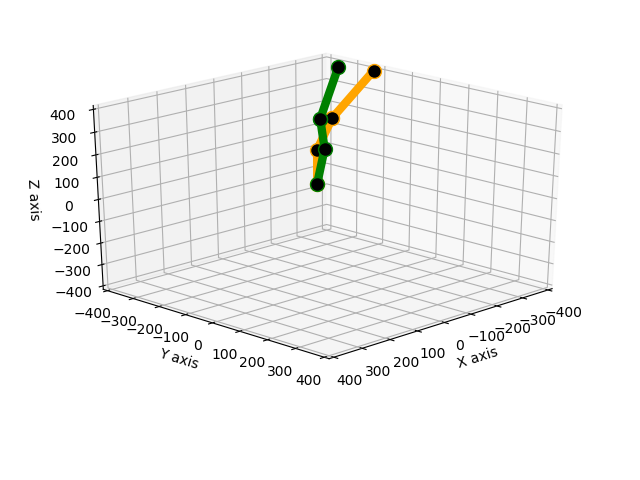

In [358]:
%matplotlib notebook
drawer = Drawer()

o = 8
drawer.draw_robot(pred_pos[o], out[o])

In [ ]:
jt, tt = generate_data(100)
print(jt)